In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import emukit.test_functions

In [2]:
np.random.seed(11)

In [3]:
def high(x):
    x1 = x[:,0]
    x2 = x[:,1]
    return (-1.275*x1**2 / np.pi**2 + 5.0*x1/np.pi + x2 - 6.0)**2 + (10.0 - 5.0/(4.0*np.pi))*np.cos(x1) + 10.0

def medium(x):
    x1 = x[:,0]
    x2 = x[:,1]
    return 10.0*np.sqrt(high(x-2.0)) + 2.0*(x1-0.5)-3.0*(3.0*x2-1.0) - 1.0

def low(x):
    x1 = x[:,0]
    x2 = x[:,1]
    return medium(1.2*(x+2.0)) - 3.0*x2 + 1.0

def scale_range(x,ub,lb):
    Np = x.shape[0]
    dim = x.shape[1]
    for i in range(0,Np):
        for j in range(0,dim):
            tmp = ub[j] -lb[j]
            x[i][j] = tmp*x[i][j] + lb[j]
    return x

N1 = 80
N2 = 40
N3 = 20

plot = 1
save = 0

dim = 2
lb = np.array([-5.0, 0.0])
ub = np.array([10.0, 15.0])

tmp = np.random.rand(1000,dim)
Xtrain = scale_range(tmp,ub,lb)
idx = np.random.permutation(1000)
X1 = Xtrain[idx[0:N1], :]
X2 = Xtrain[idx[0:N2], :]
X3 = Xtrain[idx[0:N3], :]

Y1 = low(X1)[:,None]
Y2 = medium(X2)[:,None]
Y3 = high(X3)[:,None]

nn = 40
lb = np.array([-5.0, 0.0])
ub = np.array([10.0, 15.0])
x1 = np.linspace(lb[0], ub[0], 50)
x2 = np.linspace(lb[1], ub[1], 50)
X, Y = np.meshgrid(x1, x2)

tmp = np.random.rand(1000,2)
Xtest = scale_range(tmp,ub,lb)

Exact = high(Xtest)
Medium = medium(Xtest)
Low = low(Xtest)


def rmse(pred, truth):
    pred = pred.flatten()
    truth = truth.flatten()
    return np.sqrt(np.mean((pred-truth)**2))

In [4]:
from mfGPR.mfGPR import mfGPR

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [17]:
data = {'low': {'data':[X1, Y1]},
        'high_vanilla': {'data':[X3, Y3]},
        'mid_only': {'data':[X2, Y2]},
        'mid': {'data':[X2, Y2], 'condition':'low'},
        'high': {'data':[X3, Y3], 'condition': 'mid'},
        'high_combined': {'data':[X3, Y3], 'condition': ['mid_only','low'], 'theta':[0.5, 0.5]}
        }

In [18]:
#data = {'low': {'data':[x_train_l, y_train_l]},
#        'high_vanilla': {'data':[x_train_h, y_train_h]},
#        'mid': {'data':[x_train_m, y_train_m], 'condition':['low', 'high_vanilla'], 'theta':[0.5, 0.5]},
#        'high': {'data':[x_train_h, y_train_h], 'condition': 'mid'},
#       }

In [19]:
mfGPR_models = mfGPR(data=data, n_samples=100, n_splits=5, cv_discretization=11)

Training model 'low'
Training model 'low' completed in 0.41447427272796633 m
Training model 'high_vanilla'
Training model 'high_vanilla' completed in 0.19361791213353474 m
Training model 'mid_only'
Training model 'mid_only' completed in 0.2383466879526774 m
Training model 'mid', conditioned on model(s) 'low'
Training model 'mid' completed in 0.5964390953381856 m
Training model 'high', conditioned on model(s) 'mid'
Training model 'high' completed in 0.5450307051340739 m
Training model 'high_combined', conditioned on model(s) '['mid_only', 'low']'
Training model 'high_combined' completed in 0.4964047153790792 m
All GPR models fit in: 2.484331552187602 m


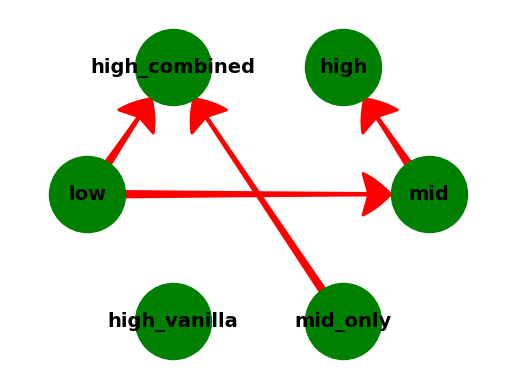

In [20]:
mfGPR_models

In [21]:
mean_low, std_low = mfGPR_models['low'].predict(Xtest)
mean_vanilla, std_vanilla = mfGPR_models['high_vanilla'].predict(Xtest)
mean_mid, std_mid = mfGPR_models['mid'].predict(Xtest)

In [22]:
mean_high, std_high = mfGPR_models['high'].predict(Xtest)

In [23]:
mean_high_combined, std_high_combined = mfGPR_models['high_combined'].predict(Xtest)

In [24]:
mfGPR_models['high_vanilla'].model

GP_regression.,value,constraints,priors
sum.kern_fidelity_1.variance,4564.591293579677,+ve,
sum.kern_fidelity_1.lengthscale,4.555312037770857,+ve,
sum.fixed.variance,1.0,+ve fixed,
Gaussian_noise.variance,0.34450139782756695,+ve,


In [25]:
mfGPR_models['high'].model

GP_regression.,value,constraints,priors
sum.mul.scale_kernel_fidelity2.variance,208.15875173812765,+ve,
sum.mul.scale_kernel_fidelity2.lengthscale,4064.4870508921767,+ve,
sum.mul.previous_fidelity_fidelity2.variance,1.0,+ve fixed,
sum.mul.previous_fidelity_fidelity2.lengthscale,14.859268858484201,+ve,
sum.bias_kernel_fidelity2.variance,5712.794893390986,+ve,
sum.bias_kernel_fidelity2.lengthscale,6.306594797802224,+ve,
sum.fixed.variance,1.0,+ve fixed,
Gaussian_noise.variance,1.087578577209546,+ve,


In [26]:
mfGPR_models['high_combined'].model

GP_regression.,value,constraints,priors
sum.mul.scale_kernel_fidelity2.variance,2814.302333425891,+ve,
sum.mul.scale_kernel_fidelity2.lengthscale,4.4126517341170945,+ve,
sum.mul.previous_fidelity_fidelity2.variance,1.0,+ve fixed,
sum.mul.previous_fidelity_fidelity2.lengthscale,123.12220576478029,+ve,
sum.bias_kernel_fidelity2.variance,1719.786555243045,+ve,
sum.bias_kernel_fidelity2.lengthscale,3624.3851872729874,+ve,
sum.fixed.variance,1.0,+ve fixed,
Gaussian_noise.variance,0.8318155379224398,+ve,


In [27]:
mfGPR_models['mid'].model

GP_regression.,value,constraints,priors
sum.mul.scale_kernel_fidelity2.variance,29137.264633434657,+ve,
sum.mul.scale_kernel_fidelity2.lengthscale,8.138098593742193,+ve,
sum.mul.previous_fidelity_fidelity2.variance,1.0,+ve fixed,
sum.mul.previous_fidelity_fidelity2.lengthscale,409.63702935905496,+ve,
sum.bias_kernel_fidelity2.variance,181.91919419149954,+ve,
sum.bias_kernel_fidelity2.lengthscale,2.8362006080606523,+ve,
sum.fixed.variance,1.0,+ve fixed,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


In [37]:
Exact = Exact[:, None]

In [38]:
np.linalg.norm(Exact - mean_high)/np.linalg.norm(Exact)

0.27401423361312255

In [39]:
np.linalg.norm(Exact - mean_high_combined)/np.linalg.norm(Exact)

0.30438663098267804

In [40]:
np.linalg.norm(Exact - mean_vanilla)/np.linalg.norm(Exact)

0.31779674908034594

In [34]:
rmse(Exact, mean_high)

20.26744511933195

In [35]:
rmse(Exact, mean_high_combined)

22.513937532201002

In [36]:
rmse(Exact, mean_vanilla)

23.505816052540858